In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext, Row
from pyspark.sql import functions as F

from pyspark.ml.feature import RFormula
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler, MinMaxScaler


import re
import random
import math

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt


In [2]:
DATA_DIR = '/shared/project/data/CMAPSSData/'
AFT_DIR  = '/shared/project/aft/'

In [3]:
# Create session and context
spark = SparkSession\
    .builder \
    .appName("Project-AFT") \
    .master("local[2]") \
    .getOrCreate()
    
sc = spark.sparkContext
sqlContext = SQLContext(sc)

#### Data Preparation

In [4]:
# Define data schema, although this is usually passed when the
# DataFrame is created, I'll be leveraging it to update the DataFrame
# using the Estimate derived class

from pyspark.sql.types import *

# Feature columns. 
feature_cols = ['cycle']

# Label columns
label_cols = ['rul', 'censor']

# Three operational setting columns
setting_cols = ['setting' + str(i) for i in range(1,4)]
feature_cols.extend(setting_cols)

# Twenty one sensor columns
sensor_cols = ['s' + str(i) for i in range(1,22)]
feature_cols.extend(sensor_cols)

# All will be read in from the training data except for RUL
# and cycle_norm which will be generated from  the existing
# data later on.
schema = StructType()\
            .add("id", IntegerType())\
            .add("cycle", IntegerType())

for c in setting_cols:
    schema.add(c, FloatType())
    
for c in sensor_cols:
    schema.add(c, FloatType())


In [5]:
# This estimator replaces the nulls, sets the column names and columns types.

from pyspark.ml import Estimator

class CleanData(Estimator):
    """ Processes a data frame to and to perform any needed
    cleaning. The schema and columns to clean are passed on object creation.
    
    Args:
        schema (StructType): Spark type object defining the target schema.
        feature_cols (list): List of column names to clean
    """
    
    def __init__(self, schema, feature_cols=None):
        self.schema = schema
        self.feature_cols = feature_cols
    
    
    def _fit(self, dataset):
        """Runs cleaning on the specified DataFrame
        
        Args:
            dataset: DataFrame to process. 
            
        Returns:
            Updated DataFrame
        """
        
        # Get summary of data set specifically to collect mean
        desc = dataset.describe().collect()
        
        # Change columns names to those passed in schema
        newDf = dataset
        for i, col in enumerate(newDf.columns):
            newDf = newDf.withColumnRenamed(col, self.schema[i].name)
    
        if self.feature_cols is not None:
            # For those columns specifed, update any non-values to the column
            # mean.
            for i, col in enumerate(newDf.columns):
                if ( col in self.feature_cols):
                    newDf = newDf.withColumn(col, F.regexp_replace(col, 'NA', str(desc[1][i+1])))
                
        # Update column type
        for i, name in enumerate(newDf.columns):
            newDf = newDf.withColumn(name, newDf[name].cast(schema[i].dataType))
                
        return newDf
   

In [6]:
!ls /shared/project/data/CMAPSSData/


Damage Propagation Modeling.pdf  RUL_FD004.txt	 train_FD001.txt
readme.txt			 test_FD001.txt  train_FD002.txt
RUL_FD001.txt			 test_FD002.txt  train_FD003.txt
RUL_FD002.txt			 test_FD003.txt  train_FD004.txt
RUL_FD003.txt			 test_FD004.txt


In [7]:
import os

fn_map = {
    "train_FD001": 1000,
    "train_FD002": 2000,
    "train_FD003": 3000,
    "train_FD004": 4000
}
    
def get_data_set_name(path):
    filename = os.path.basename(path)
    fn = os.path.splitext(filename)[0]
    return fn_map.get(fn)

# Used to map data set file name to an integer to be combined
# with the id. This will give us unique ids across all
# data set files.
data_set_name = F.udf(lambda path: get_data_set_name(path))

In [8]:
print( get_data_set_name('/shared/project/data/CMAPSSData/train_FD001.txt'))

1000


In [9]:
# Load the data files. Note if we attempt to apply the schema by
# running the data through the CleanData Estimator will process
# the data.

df_train = spark.read.format("csv")\
    .option("delimiter", " ")\
    .option("header", "false")\
    .load(DATA_DIR+'train_FD*.txt', inferSchema=True)\
    .withColumn('_c0', F.col('_c0') + data_set_name(F.input_file_name()))\
    .drop('_c26').drop('_c27')


In [13]:

# Fix the dataframe
cn = CleanData(schema)

df_train = cn.fit(df_train)
df_train.show(5)


+----+-----+--------+--------+--------+------+------+-------+-------+----+-----+------+-------+-------+----+-----+------+-------+-------+-------+----+-----+------+-----+-----+-------+
|  id|cycle|setting1|setting2|setting3|    s1|    s2|     s3|     s4|  s5|   s6|    s7|     s8|     s9| s10|  s11|   s12|    s13|    s14|    s15| s16|  s17|   s18|  s19|  s20|    s21|
+----+-----+--------+--------+--------+------+------+-------+-------+----+-----+------+-------+-------+----+-----+------+-------+-------+-------+----+-----+------+-----+-----+-------+
|4001|    1| 42.0049|    0.84|   100.0| 445.0|549.68|1343.43|1112.93|3.91|  5.7|137.36|2211.86|8311.32|1.01|41.69|129.78|2387.99|8074.83| 9.3335|0.02|330.0|2212.0|100.0|10.62|  6.367|
|4001|    2|  20.002|  0.7002|   100.0|491.19|606.07|1477.61| 1237.5|9.35|13.61| 332.1|2323.66| 8713.6|1.07|43.94|312.59|2387.73|8046.13| 9.1913|0.02|361.0|2324.0|100.0|24.37|14.6552|
|4001|    3| 42.0038|  0.8409|   100.0| 445.0|548.95|1343.12|1117.05|3.91| 5.69|

In [14]:
df_train.printSchema()

root
 |-- id: integer (nullable = true)
 |-- cycle: integer (nullable = true)
 |-- setting1: float (nullable = true)
 |-- setting2: float (nullable = true)
 |-- setting3: float (nullable = true)
 |-- s1: float (nullable = true)
 |-- s2: float (nullable = true)
 |-- s3: float (nullable = true)
 |-- s4: float (nullable = true)
 |-- s5: float (nullable = true)
 |-- s6: float (nullable = true)
 |-- s7: float (nullable = true)
 |-- s8: float (nullable = true)
 |-- s9: float (nullable = true)
 |-- s10: float (nullable = true)
 |-- s11: float (nullable = true)
 |-- s12: float (nullable = true)
 |-- s13: float (nullable = true)
 |-- s14: float (nullable = true)
 |-- s15: float (nullable = true)
 |-- s16: float (nullable = true)
 |-- s17: float (nullable = true)
 |-- s18: float (nullable = true)
 |-- s19: float (nullable = true)
 |-- s20: float (nullable = true)
 |-- s21: float (nullable = true)



Calculate the Remaining Useful Life (RUL). The number of entries per engine id corresponds to the life of the engine.

In [15]:
rul_df = df_train\
    .groupBy('id')\
    .count()\
    .orderBy( F.asc('id'))\
    .select( F.col('id').alias('engine_id'), F.col('count').alias('rul'))

rul_df.show(5)            

+---------+---+
|engine_id|rul|
+---------+---+
|     1001|192|
|     1002|287|
|     1003|179|
|     1004|189|
|     1005|269|
+---------+---+
only showing top 5 rows



In [16]:
df_train.cache()
df_train.createOrReplaceTempView('train')

rul_df.createOrReplaceTempView('rul')
rul_df.cache()

j_type = 'inner'
j_exp = df_train['id'] == rul_df['engine_id']

# Join on the engine id then delete the duplicate column
df_train = df_train\
                .join( rul_df, j_exp)\
                .drop( F.col('engine_id'))

df_train.show(5)

+----+-----+--------+--------+--------+------+------+-------+-------+----+-----+------+-------+-------+----+-----+------+-------+-------+-------+----+-----+------+-----+-----+-------+---+
|  id|cycle|setting1|setting2|setting3|    s1|    s2|     s3|     s4|  s5|   s6|    s7|     s8|     s9| s10|  s11|   s12|    s13|    s14|    s15| s16|  s17|   s18|  s19|  s20|    s21|rul|
+----+-----+--------+--------+--------+------+------+-------+-------+----+-----+------+-------+-------+----+-----+------+-------+-------+-------+----+-----+------+-----+-----+-------+---+
|4001|    1| 42.0049|    0.84|   100.0| 445.0|549.68|1343.43|1112.93|3.91|  5.7|137.36|2211.86|8311.32|1.01|41.69|129.78|2387.99|8074.83| 9.3335|0.02|330.0|2212.0|100.0|10.62|  6.367|321|
|4001|    2|  20.002|  0.7002|   100.0|491.19|606.07|1477.61| 1237.5|9.35|13.61| 332.1|2323.66| 8713.6|1.07|43.94|312.59|2387.73|8046.13| 9.1913|0.02|361.0|2324.0|100.0|24.37|14.6552|321|
|4001|    3| 42.0038|  0.8409|   100.0| 445.0|548.95|1343.12

At this point the rul column shows the total life of the engine. To truly make it an RUL, subtract the cycle time. The result per engine will be a montonically decreasing value with the last entry having an rul value of 1. Fit fails when label is zero.

In [17]:
df_train = df_train.withColumn("rul", F.col('rul')-F.col('cycle')+1)
df_train.show(5)


+----+-----+--------+--------+--------+------+------+-------+-------+----+-----+------+-------+-------+----+-----+------+-------+-------+-------+----+-----+------+-----+-----+-------+---+
|  id|cycle|setting1|setting2|setting3|    s1|    s2|     s3|     s4|  s5|   s6|    s7|     s8|     s9| s10|  s11|   s12|    s13|    s14|    s15| s16|  s17|   s18|  s19|  s20|    s21|rul|
+----+-----+--------+--------+--------+------+------+-------+-------+----+-----+------+-------+-------+----+-----+------+-------+-------+-------+----+-----+------+-----+-----+-------+---+
|4001|    1| 42.0049|    0.84|   100.0| 445.0|549.68|1343.43|1112.93|3.91|  5.7|137.36|2211.86|8311.32|1.01|41.69|129.78|2387.99|8074.83| 9.3335|0.02|330.0|2212.0|100.0|10.62|  6.367|321|
|4001|    2|  20.002|  0.7002|   100.0|491.19|606.07|1477.61| 1237.5|9.35|13.61| 332.1|2323.66| 8713.6|1.07|43.94|312.59|2387.73|8046.13| 9.1913|0.02|361.0|2324.0|100.0|24.37|14.6552|320|
|4001|    3| 42.0038|  0.8409|   100.0| 445.0|548.95|1343.12

In [18]:
df_train.where( (F.col('id') == 1) & (F.col('cycle') > 187) ).show()

+---+-----+--------+--------+--------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
| id|cycle|setting1|setting2|setting3| s1| s2| s3| s4| s5| s6| s7| s8| s9|s10|s11|s12|s13|s14|s15|s16|s17|s18|s19|s20|s21|rul|
+---+-----+--------+--------+--------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
+---+-----+--------+--------+--------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+



Create the censor column for use by AFTSurvivalRegression. A value of 1 means uncensored (the event has occurred). I set all the engines in the training data to uncensored under the assumptions that the the failure event is known and is the last entry in the cycle life of that engine. However, I experimented with different settings and confirmed that setting all the uncensored gave the best result. 

1. all uncensored - all_ones = MSE:327
2. all censored - all_zero = MSE:4.0442525914535675e+23
3. only last uncensored - last_1 = MSE: 2.014760097058678e+20
4. only last censdored last_0 = MSE: 516.7826080344316
5. time window uncensored - fails


In [19]:
cycle_window = 0 # For ATF Regressions    
    
df_train = df_train\
    .withColumn('censor',\
        F.when(df_train.rul <= cycle_window, F.lit(0))\
        .otherwise(F.lit(1)))

df_train.show(5)

+----+-----+--------+--------+--------+------+------+-------+-------+----+-----+------+-------+-------+----+-----+------+-------+-------+-------+----+-----+------+-----+-----+-------+---+------+
|  id|cycle|setting1|setting2|setting3|    s1|    s2|     s3|     s4|  s5|   s6|    s7|     s8|     s9| s10|  s11|   s12|    s13|    s14|    s15| s16|  s17|   s18|  s19|  s20|    s21|rul|censor|
+----+-----+--------+--------+--------+------+------+-------+-------+----+-----+------+-------+-------+----+-----+------+-------+-------+-------+----+-----+------+-----+-----+-------+---+------+
|4001|    1| 42.0049|    0.84|   100.0| 445.0|549.68|1343.43|1112.93|3.91|  5.7|137.36|2211.86|8311.32|1.01|41.69|129.78|2387.99|8074.83| 9.3335|0.02|330.0|2212.0|100.0|10.62|  6.367|321|     1|
|4001|    2|  20.002|  0.7002|   100.0|491.19|606.07|1477.61| 1237.5|9.35|13.61| 332.1|2323.66| 8713.6|1.07|43.94|312.59|2387.73|8046.13| 9.1913|0.02|361.0|2324.0|100.0|24.37|14.6552|320|     1|
|4001|    3| 42.0038|  0.

Scale cycle, operational settings, and sensor features.


In [20]:
cols = feature_cols + label_cols

subset_df = df_train.select([c for c in df_train.columns if c in cols])
subset_df.show(5)


+-----+--------+--------+--------+------+------+-------+-------+----+-----+------+-------+-------+----+-----+------+-------+-------+-------+----+-----+------+-----+-----+-------+---+------+
|cycle|setting1|setting2|setting3|    s1|    s2|     s3|     s4|  s5|   s6|    s7|     s8|     s9| s10|  s11|   s12|    s13|    s14|    s15| s16|  s17|   s18|  s19|  s20|    s21|rul|censor|
+-----+--------+--------+--------+------+------+-------+-------+----+-----+------+-------+-------+----+-----+------+-------+-------+-------+----+-----+------+-----+-----+-------+---+------+
|    1| 42.0049|    0.84|   100.0| 445.0|549.68|1343.43|1112.93|3.91|  5.7|137.36|2211.86|8311.32|1.01|41.69|129.78|2387.99|8074.83| 9.3335|0.02|330.0|2212.0|100.0|10.62|  6.367|321|     1|
|    2|  20.002|  0.7002|   100.0|491.19|606.07|1477.61| 1237.5|9.35|13.61| 332.1|2323.66| 8713.6|1.07|43.94|312.59|2387.73|8046.13| 9.1913|0.02|361.0|2324.0|100.0|24.37|14.6552|320|     1|
|    3| 42.0038|  0.8409|   100.0| 445.0|548.95|13

In [21]:
# Label columns

r_formula = 'rul ~ ' + '+'.join(feature_cols)

formula = RFormula(formula=r_formula)
formula_model = formula.fit(subset_df)

preparedDF = formula_model.transform(subset_df)
preparedDF.show(5)


+-----+--------+--------+--------+------+------+-------+-------+----+-----+------+-------+-------+----+-----+------+-------+-------+-------+----+-----+------+-----+-----+-------+---+------+--------------------+-----+
|cycle|setting1|setting2|setting3|    s1|    s2|     s3|     s4|  s5|   s6|    s7|     s8|     s9| s10|  s11|   s12|    s13|    s14|    s15| s16|  s17|   s18|  s19|  s20|    s21|rul|censor|            features|label|
+-----+--------+--------+--------+------+------+-------+-------+----+-----+------+-------+-------+----+-----+------+-------+-------+-------+----+-----+------+-----+-----+-------+---+------+--------------------+-----+
|    1| 42.0049|    0.84|   100.0| 445.0|549.68|1343.43|1112.93|3.91|  5.7|137.36|2211.86|8311.32|1.01|41.69|129.78|2387.99|8074.83| 9.3335|0.02|330.0|2212.0|100.0|10.62|  6.367|321|     1|[1.0,42.004901885...|321.0|
|    2|  20.002|  0.7002|   100.0|491.19|606.07|1477.61| 1237.5|9.35|13.61| 332.1|2323.66| 8713.6|1.07|43.94|312.59|2387.73|8046.13|

In [22]:

# TODO Need to checkout the std
#scaler = StandardScaler(inputCol="features", 
#                        outputCol="scaledFeatures",
#                        withStd=True, 
#                        withMean=True)

scaler = MinMaxScaler(inputCol="features", 
                      outputCol="scaledFeatures")

scaler_model = scaler.fit(preparedDF)

# Standized each feature
scaledData = scaler_model.transform(preparedDF)

#print("Features scaled to range: [%f, %f]" % (scaler.getMin(), scaler.getMax()))


In [23]:
scaledData.show(5)

+-----+--------+--------+--------+------+------+-------+-------+----+-----+------+-------+-------+----+-----+------+-------+-------+-------+----+-----+------+-----+-----+-------+---+------+--------------------+-----+--------------------+
|cycle|setting1|setting2|setting3|    s1|    s2|     s3|     s4|  s5|   s6|    s7|     s8|     s9| s10|  s11|   s12|    s13|    s14|    s15| s16|  s17|   s18|  s19|  s20|    s21|rul|censor|            features|label|      scaledFeatures|
+-----+--------+--------+--------+------+------+-------+-------+----+-----+------+-------+-------+----+-----+------+-------+-------+-------+----+-----+------+-----+-----+-------+---+------+--------------------+-----+--------------------+
|    1| 42.0049|    0.84|   100.0| 445.0|549.68|1343.43|1112.93|3.91|  5.7|137.36|2211.86|8311.32|1.01|41.69|129.78|2387.99|8074.83| 9.3335|0.02|330.0|2212.0|100.0|10.62|  6.367|321|     1|[1.0,42.004901885...|321.0|[0.0,0.9999262784...|
|    2|  20.002|  0.7002|   100.0|491.19|606.07|

In [24]:
scaledData.select("features", "scaledFeatures", "label", "censor").show(5)


+--------------------+--------------------+-----+------+
|            features|      scaledFeatures|label|censor|
+--------------------+--------------------+-----+------+
|[1.0,42.004901885...|[0.0,0.9999262784...|321.0|     1|
|[2.0,20.002000808...|[0.00184501845018...|320.0|     1|
|[3.0,42.003799438...|[0.00369003690036...|319.0|     1|
|[4.0,42.0,0.83999...|[0.00553505535055...|318.0|     1|
|[5.0,25.006299972...|[0.00738007380073...|317.0|     1|
+--------------------+--------------------+-----+------+
only showing top 5 rows



In [25]:
f_df = scaledData.select("features").collect()
f_df[0][0]

DenseVector([1.0, 42.0049, 0.84, 100.0, 445.0, 549.68, 1343.4301, 1112.9301, 3.91, 5.7, 137.36, 2211.8601, 8311.3203, 1.01, 41.69, 129.78, 2387.99, 8074.8301, 9.3335, 0.02, 330.0, 2212.0, 100.0, 10.62, 6.367])

In [26]:
s_df = scaledData.select("scaledFeatures").collect()
s_df[0][0]

DenseVector([0.0, 0.9999, 0.9976, 1.0, 0.0, 0.1295, 0.2692, 0.2134, 0.0, 0.0019, 0.0027, 0.627, 0.2594, 0.2051, 0.4524, 0.0036, 0.9931, 0.5113, 0.4045, 0.0, 0.2857, 0.6279, 1.0, 0.0155, 0.0199])

### Train

In [27]:
from pyspark.ml.regression import AFTSurvivalRegression

aft = AFTSurvivalRegression(censorCol='censor', 
                            featuresCol='scaledFeatures', 
                            labelCol='rul', maxIter=500, tol=1e-8)

aft_model = aft.fit(scaledData)

# Print the coefficients, intercept and scale parameter for AFT survival regression
print("Coefficients: " + str(aft_model.coefficients))
print("Intercept: " + str(aft_model.intercept))
print("Scale: " + str(aft_model.scale))

pred = aft_model.transform(scaledData)


Coefficients: [-1.3860091086473996,5.460502226454825,-3.275009509857952,0.641887388393225,18.877903473195964,-11.439644434622585,-3.011049679224845,-5.210749789735106,-1.9888600150802862,-1.054201025191529,-4.3498003752253585,8.186633100925246,-10.952460178661676,3.344903637816549,-9.423513046077497,-5.200676477298902,-1.4138141408768121,-1.0925234321145982,-4.462547159687742,-0.1969447958636199,-3.1326292155082993,9.875226460424951,0.641887388393225,7.35580774822707,6.146335037956176]
Intercept: 5.195516436735067
Scale: 0.42324651574338756


### Save models for later use

In [28]:
model_dir = AFT_DIR + 'models/'

# Uncomment to overwrite the model
aft_model.write().overwrite().save(model_dir+'aft')
formula_model.write().overwrite().save(model_dir+'formula')
scaler_model.write().overwrite().save(model_dir+'scaler')

In [29]:
pred_values = np.array(pred.select('prediction').collect())
rul_values = np.array(subset_df.select("rul").collect())

pred_values.shape

(160359, 1)

In [30]:
summary = pred.select( F.col('rul')-F.col('prediction'))
summary.show()

+-------------------+
| (rul - prediction)|
+-------------------+
| 14.704854238994812|
| -103.3994747760425|
|  9.652608668152709|
| -48.47001055238729|
| -7.722584938090677|
|-102.10235843022326|
|  -96.8214022109621|
|-26.407756991708823|
| -184.6022659681646|
| -8.442451631395556|
|-137.79912056188113|
|-19.164420933803683|
| -19.01860100865548|
|  7.742407387238586|
| 14.430584992623608|
| -91.57794706536345|
| -127.0565657878135|
|-20.819866329123954|
| -8.736086552078348|
|  -40.7414947018371|
+-------------------+
only showing top 20 rows



### Evalutate Model

In [31]:
# Load the data file. Note if we attempt to apply the schema, the rows 
# with corrupt entries will be set to null. To attempt to preserve them
# the CleanData Estimator will process the data.

data_set_unit = 'FD002'

df_test_x = spark.read.format("csv")\
    .option("delimiter", " ")\
    .option("header", "false")\
    .load(DATA_DIR+'test_'+data_set_unit+'.txt', inferSchema=True)\
    .drop('_c26').drop('_c27')

# Fix the dataframe
df_test_x = cn.fit(df_test_x)

print("test_x")
df_test_x.show(5)

# Load the data file. Note if we attempt to apply the schema, the rows 
# with corrupt entries will be set to null. To attempt to preserve them
# the CleanData Estimator will process the data.

df_test_y = spark.read.format("csv")\
    .option("delimiter", ",")\
    .option("header", "false")\
    .load(DATA_DIR+'RUL_'+data_set_unit+'.txt', inferSchema=True)


# Add id for each engine
df_test_y = df_test_y\
            .withColumn('engine_id', F.monotonically_increasing_id()+1)

# Fix type and column name 
test_y_schema = StructType()\
   .add("rul", IntegerType())\
   .add("engine_id", IntegerType())

cn_test_y = CleanData(test_y_schema)
df_test_y = cn_test_y.fit(df_test_y).select('engine_id', 'rul')

print("test_y")
df_test_y.show(5)


test_x
+---+-----+--------+--------+--------+------+------+-------+-------+-----+-----+------+-------+-------+----+-----+------+-------+-------+-------+----+-----+------+-----+-----+-------+
| id|cycle|setting1|setting2|setting3|    s1|    s2|     s3|     s4|   s5|   s6|    s7|     s8|     s9| s10|  s11|   s12|    s13|    s14|    s15| s16|  s17|   s18|  s19|  s20|    s21|
+---+-----+--------+--------+--------+------+------+-------+-------+-----+-----+------+-------+-------+----+-----+------+-------+-------+-------+----+-----+------+-----+-----+-------+
|  1|    1|  9.9987|  0.2502|   100.0|489.05|605.03|1497.17|1304.99|10.52|15.49|394.54|2318.96| 8763.8|1.26|45.61|371.69|2388.18| 8114.1| 8.6476|0.03|369.0|2319.0|100.0|28.42|17.1551|
|  1|    2| 20.0026|     0.7|   100.0|491.19|607.82| 1481.2|1246.11| 9.35|13.66|334.36|2323.95|8713.21|1.08|44.26|315.32|2388.12|8053.06| 9.2405|0.02|364.0|2324.0|100.0|24.29|14.8039|
|  1|    3| 35.0045|    0.84|   100.0|449.44| 556.0|1359.08|1128.36| 5.48

This test data was originally used to evaluate the contestant and was not known. The RUL in test_y specifies the RUL at the last cycle of test data. The RUL column we will add will end at the test_y value.

In [32]:
df_test_x.cache()
df_test_x.createOrReplaceTempView('test_x')

df_test_y.createOrReplaceTempView('test_y')
df_test_y.cache()

test_x_cycles_df = df_test_x\
    .groupBy('id')\
    .count()\
    .orderBy( F.asc('id'))\
    .select( F.col('id').alias('cycle_engine_id'), F.col('count').alias('cycles'))


# Number of cycles plus the RUL is the starting RUL of the test data
test_x_cycles_df = test_x_cycles_df\
                    .join(df_test_y, test_x_cycles_df['cycle_engine_id'] == df_test_y['engine_id'])\
                    .drop( F.col('cycle_engine_id'))\
                    .select('engine_id', (F.col('cycles')+F.col('rul')).alias('rul'))

test_x_cycles_df.show(5)     

+---------+---+
|engine_id|rul|
+---------+---+
|        1|276|
|        2|134|
|        3|271|
|        4|196|
|        5|163|
+---------+---+
only showing top 5 rows



In [33]:
num_test_engines = test_x_cycles_df.count()
num_test_engines

259

In [34]:
df_test_x.show(5)


+---+-----+--------+--------+--------+------+------+-------+-------+-----+-----+------+-------+-------+----+-----+------+-------+-------+-------+----+-----+------+-----+-----+-------+
| id|cycle|setting1|setting2|setting3|    s1|    s2|     s3|     s4|   s5|   s6|    s7|     s8|     s9| s10|  s11|   s12|    s13|    s14|    s15| s16|  s17|   s18|  s19|  s20|    s21|
+---+-----+--------+--------+--------+------+------+-------+-------+-----+-----+------+-------+-------+----+-----+------+-------+-------+-------+----+-----+------+-----+-----+-------+
|  1|    1|  9.9987|  0.2502|   100.0|489.05|605.03|1497.17|1304.99|10.52|15.49|394.54|2318.96| 8763.8|1.26|45.61|371.69|2388.18| 8114.1| 8.6476|0.03|369.0|2319.0|100.0|28.42|17.1551|
|  1|    2| 20.0026|     0.7|   100.0|491.19|607.82| 1481.2|1246.11| 9.35|13.66|334.36|2323.95|8713.21|1.08|44.26|315.32|2388.12|8053.06| 9.2405|0.02|364.0|2324.0|100.0|24.29|14.8039|
|  1|    3| 35.0045|    0.84|   100.0|449.44| 556.0|1359.08|1128.36| 5.48|  8.0|

In [35]:

j_exp = df_test_x['id'] == test_x_cycles_df['engine_id']

# Join on the engine id then delete the duplicate column
df_test_x = df_test_x\
                .join( test_x_cycles_df, j_exp)\
                .drop( F.col('engine_id'))\
                .withColumn("rul", F.col('rul')-F.col('cycle'))\
                .orderBy( F.asc('id'), F.asc('cycle'))

df_test_x.show(31)


+---+-----+--------+--------+--------+------+------+-------+-------+-----+-----+------+-------+-------+----+-----+------+-------+-------+-------+----+-----+------+-----+-----+-------+---+
| id|cycle|setting1|setting2|setting3|    s1|    s2|     s3|     s4|   s5|   s6|    s7|     s8|     s9| s10|  s11|   s12|    s13|    s14|    s15| s16|  s17|   s18|  s19|  s20|    s21|rul|
+---+-----+--------+--------+--------+------+------+-------+-------+-----+-----+------+-------+-------+----+-----+------+-------+-------+-------+----+-----+------+-----+-----+-------+---+
|  1|    1|  9.9987|  0.2502|   100.0|489.05|605.03|1497.17|1304.99|10.52|15.49|394.54|2318.96| 8763.8|1.26|45.61|371.69|2388.18| 8114.1| 8.6476|0.03|369.0|2319.0|100.0|28.42|17.1551|275|
|  1|    2| 20.0026|     0.7|   100.0|491.19|607.82| 1481.2|1246.11| 9.35|13.66|334.36|2323.95|8713.21|1.08|44.26|315.32|2388.12|8053.06| 9.2405|0.02|364.0|2324.0|100.0|24.29|14.8039|274|
|  1|    3| 35.0045|    0.84|   100.0|449.44| 556.0|1359.08|

In [36]:

test_preparedDF = formula_model.transform(df_test_x)
test_preparedDF.show(5)

test_scaledData = scaler_model.transform(test_preparedDF)
test_scaledData.show(5)

+---+-----+--------+--------+--------+------+------+-------+-------+-----+-----+------+-------+-------+----+-----+------+-------+-------+-------+----+-----+------+-----+-----+-------+---+--------------------+-----+
| id|cycle|setting1|setting2|setting3|    s1|    s2|     s3|     s4|   s5|   s6|    s7|     s8|     s9| s10|  s11|   s12|    s13|    s14|    s15| s16|  s17|   s18|  s19|  s20|    s21|rul|            features|label|
+---+-----+--------+--------+--------+------+------+-------+-------+-----+-----+------+-------+-------+----+-----+------+-------+-------+-------+----+-----+------+-----+-----+-------+---+--------------------+-----+
|  1|    1|  9.9987|  0.2502|   100.0|489.05|605.03|1497.17|1304.99|10.52|15.49|394.54|2318.96| 8763.8|1.26|45.61|371.69|2388.18| 8114.1| 8.6476|0.03|369.0|2319.0|100.0|28.42|17.1551|275|[1.0,9.9987001419...|275.0|
|  1|    2| 20.0026|     0.7|   100.0|491.19|607.82| 1481.2|1246.11| 9.35|13.66|334.36|2323.95|8713.21|1.08|44.26|315.32|2388.12|8053.06| 9.

In [37]:
def calc_rmse(predictions):
    mse = lambda y,p: (y-p)**2

    rmse = predictions.select('id', 'cycle', 'rul', 'prediction').withColumn('se', mse(F.col('rul'),F.col('prediction')) ).select( F.sqrt(F.mean('se')).alias('rmse')).collect()
    return rmse[0].__getitem__("rmse")


In [38]:

pred_test = aft_model.transform(test_scaledData)

pred_rmse = calc_rmse(pred_test)
print("RMSE: ", pred_rmse)

RMSE:  50.01015192833228


In [39]:
def display_engine_prediction(engine_ids, predictions):
    
    engine_ids.sort()
    
    # Total plots 
    n = len(engine_ids)
     
    ncols = max(n//3,1)
    nrows = math.ceil(n/ncols)
        
    fig = plt.figure(figsize=(20, 10))
    
    for i, engine_id in enumerate(engine_ids):

        # Collect the data per engine
        engine_data = predictions.select('cycle', 'rul', 'prediction').filter( F.col('id') == engine_id).orderBy( F.col('cycle').asc())

        cycle = np.array(engine_data.select('cycle').collect())
        rul = np.array(engine_data.select('rul').collect())
        prediction = np.array(engine_data.select('prediction').collect())
        
        ax = plt.subplot(nrows, ncols, i+1)

        l1, = ax.plot( cycle, rul, label='RUL')
        l2, = ax.plot( cycle, prediction, label='Prediction')
        ax.set_xlabel('cycle')
        ax.set_ylabel('RUL')
        ax.set_ylim(0)
        plt.title("Engine: {}".format(engine_id))

    fig.legend((l1,l2), ('Actual', 'Prediction'), 'upper right')
    plt.tight_layout()
    
    plt.show()

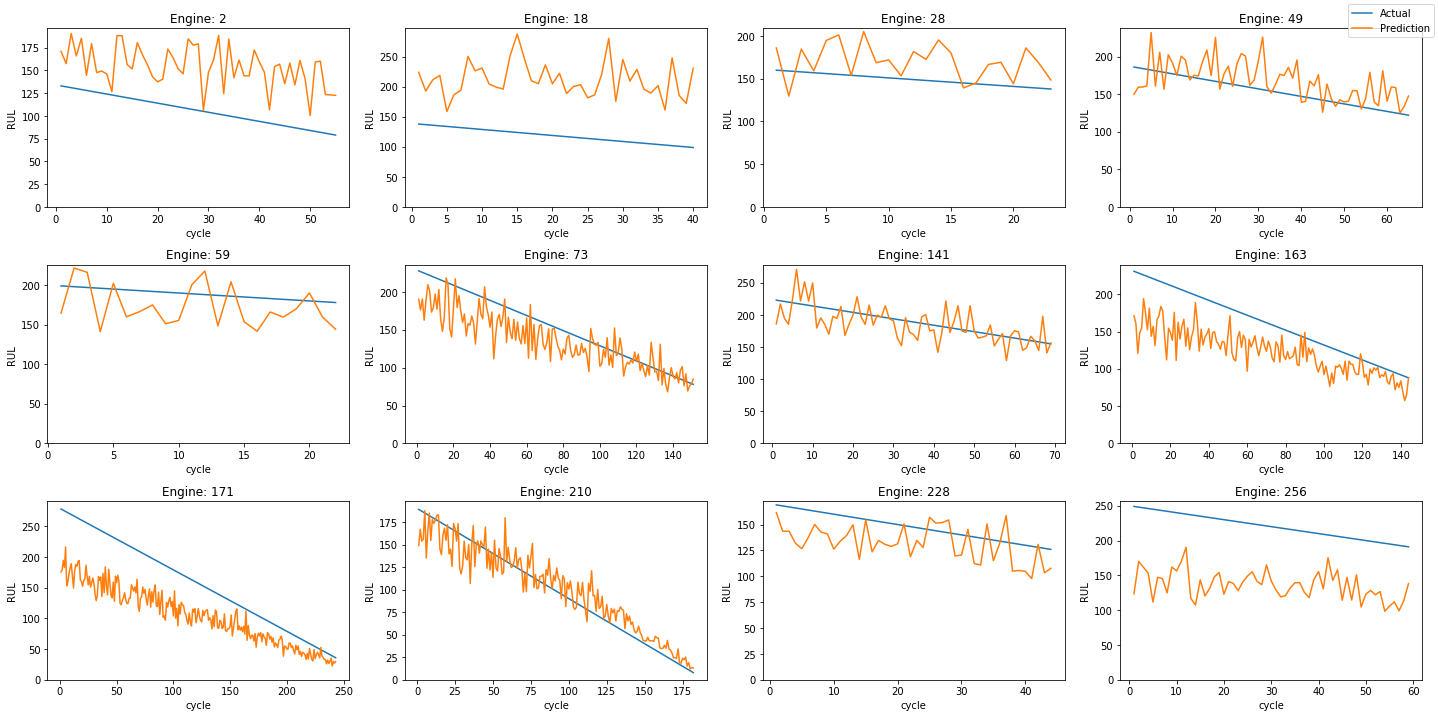

In [40]:
# Select 10 engines at random

engine_ids = random.sample(range(1,num_test_engines+1), 12)
display_engine_prediction(engine_ids, pred_test)